In [1]:
# imports:

import pandas as pd
import numpy as np

import pymc3 as pm
import arviz as az

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# settings:

sns.set()
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 300
az.style.use("arviz-darkgrid")

In [3]:
# read in the data (produced in 'data_generation.ipynb'):

dfi = pd.read_csv('data.csv', index_col=0)
dfi.head()

,spacing,phi,Sw,h,RF,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eurpft
0,382.591997,0.061288,0.403978,345.151835,0.042293,31.579886,40,1263.195436,27.949333
1,391.775828,0.069508,0.286578,377.646100,0.054421,45.538643,40,1821.545703,54.699897
2,395.298148,0.070656,0.326500,425.038494,0.060490,46.427545,50,2321.377239,66.258736
3,397.503239,0.064701,0.263928,490.995683,0.053622,44.971919,40,1798.876778,68.283179
4,397.861357,0.055772,0.277591,379.987072,0.047559,33.743429,50,1687.171463,39.687829


In [4]:
# drop some columns not used in the model:

df = dfi.drop(['phi', 'Sw', 'h', 'RF'], axis=1)
df.head()

,spacing,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eurpft
0,382.591997,31.579886,40,1263.195436,27.949333
1,391.775828,45.538643,40,1821.545703,54.699897
2,395.298148,46.427545,50,2321.377239,66.258736
3,397.503239,44.971919,40,1798.876778,68.283179
4,397.861357,33.743429,50,1687.171463,39.687829


In [5]:
# create our familiar modified sigmoid function:

def mod_sig(spacing, k, L, b0):
    return (2 * (L - b0)) / (1 + np.exp(-k * (spacing - 0))) - (2 * (L - b0)) / 2 + b0

In [6]:
# use the fit line from the frequentist regression approach for comparison:

regfit = mod_sig(df['spacing'], .00159, 95.34, 33.36)

Text(0.5, 0, 'In-Zone Spacing (ft)')

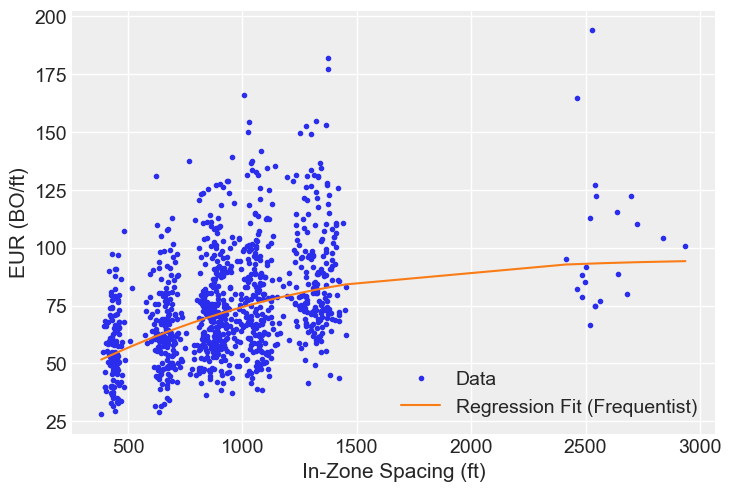

In [7]:
# visualize the frequentist regression line:

plt.plot(df['spacing'], df['eurpft'], '.', label='Data')
plt.plot(df['spacing'], regfit, label='Regression Fit (Frequentist)')
plt.legend()
plt.ylabel('EUR (BO/ft)')
plt.xlabel('In-Zone Spacing (ft)')

## I'll start the Bayesian modeling approach using a simplified process model: treating spacing as the sole observed determinant: 

In [8]:
# construct the Bayesian model and sample from the posterior:

with pm.Model() as mod:
    # minimally informative priors:
    L = pm.Normal('L', 100, 5)
    k = pm.Uniform('k', .0001, .01)
    b0 = pm.Uniform('b0', 1, 50)
    sigma = pm.Uniform('sigma', 1, 3) 
    
    # the fit line:
    mu = (2 * (L - b0)) / (1 + np.exp(-k * (df['spacing'] - 0))) - (2 * (L - b0)) / 2 + b0
    
    # and the posterior distribution:
    post = pm.Lognormal('post', mu=np.log(mu), sigma=np.log(sigma), observed=df['eurpft'])

    trace = pm.sample(1000)

C:\Users\samue\AppData\Local\Temp\ipykernel_24856\2283635285.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b0, k, L]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 196 seconds.
The acceptance probability does not match the target. It is 0.8933803565377013, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\samue\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


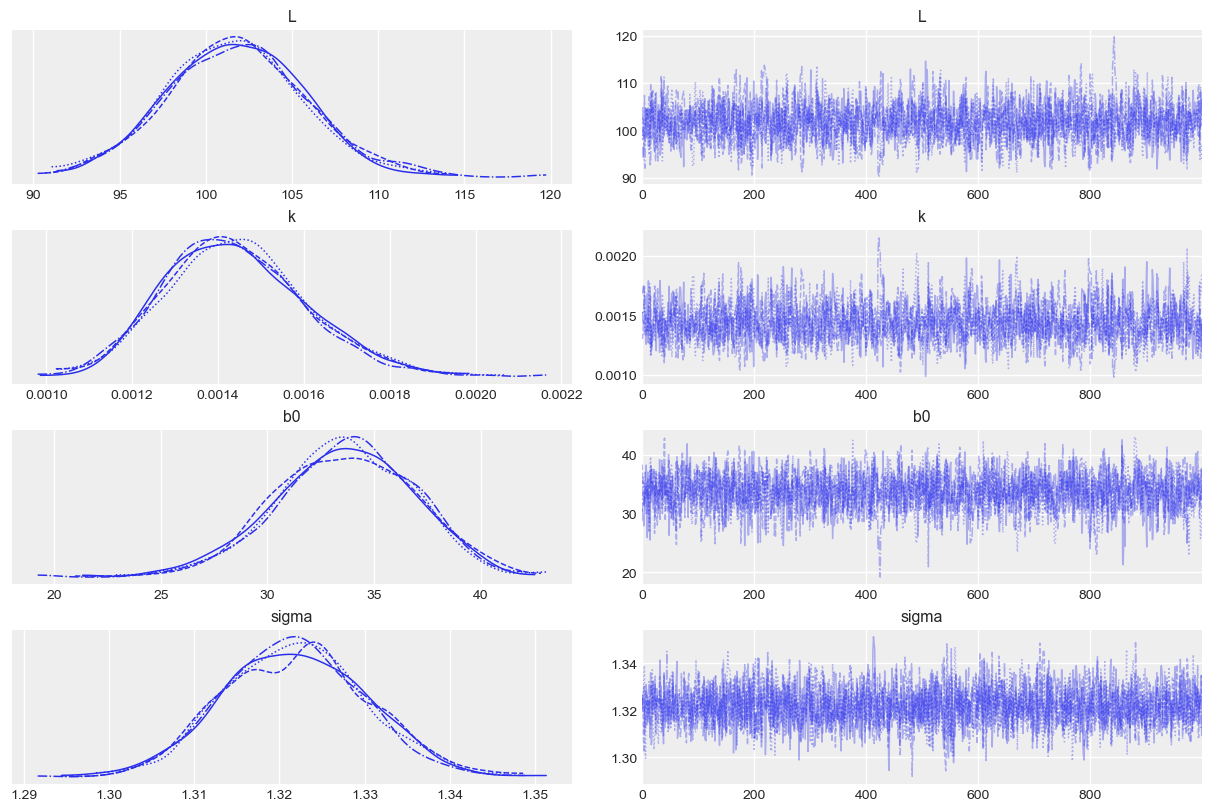

In [9]:
# plot the traces:

az.plot_trace(trace);

In [10]:
# assign the mean of each parameter to a variable:

Lb = trace['L'].mean()
kb = trace['k'].mean()
b0b = trace['b0'].mean()

yhat_bayes = (2 * (Lb - b0b)) / (1 + np.exp(-kb * (df['spacing'] - 0))) - (2 * (Lb - b0b)) / 2 + b0b

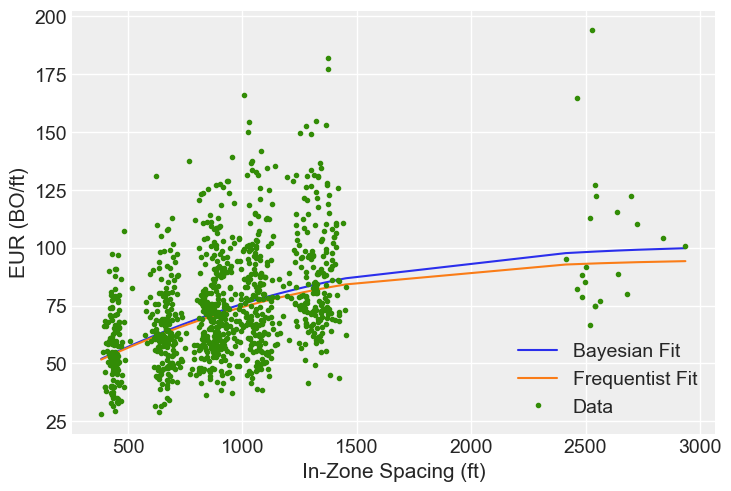

In [11]:
plt.plot(df['spacing'], yhat_bayes, label='Bayesian Fit')
plt.plot(df['spacing'], regfit, label='Frequentist Fit')
plt.plot(df['spacing'], df['eurpft'], '.', label='Data')
plt.ylabel('EUR (BO/ft)')
plt.xlabel('In-Zone Spacing (ft)')
plt.legend()

## Now I'll introduce the (linear scaling) effects of completion fluid intensity & completion sand concentration:

In [12]:
# I'll try the estimation using only a fraction of the data
# (more like typical data availability at the asset or field level):

spcg = df['spacing'][::30]
eurpft = df['eurpft'][::30]
fl_int = df['compl_bbl_per_ft'][::30]
sd = df['compl_sd_conc'][::30]


In [13]:
# construct the model and sample from the posterior:

with pm.Model() as mod2:
    # priors:
    L = pm.Uniform('L', 70, 150)
    k = pm.Uniform('k', .0001, .002)
    b0 = pm.Uniform('b0', 10, 60)
    b1 = pm.Uniform('b1', 0, 2)
    b2 = pm.Uniform('b2', 0, 1)
    sigma = pm.Uniform('sigma', 1.01, 3)
    
    sd_mult = ((sd.values - 40) * b2 / 40 + 1)
    fl_mult = ((fl_int.values - 45) * b1 / 45 + 1)
    
    mu = fl_mult * sd_mult * (2 * (L - b0)) / (1 + np.exp(-k * (spcg - 0))) - (2 * (L - b0)) / 2 + b0
    
    post = pm.Lognormal('post', mu=np.log(mu), sigma=np.log(sigma), observed=eurpft) 

    trace2 = pm.sample()

C:\Users\samue\AppData\Local\Temp\ipykernel_24856\825494911.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace2 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, b0, k, L]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6663199852125861, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6443136732281001, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\samue\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


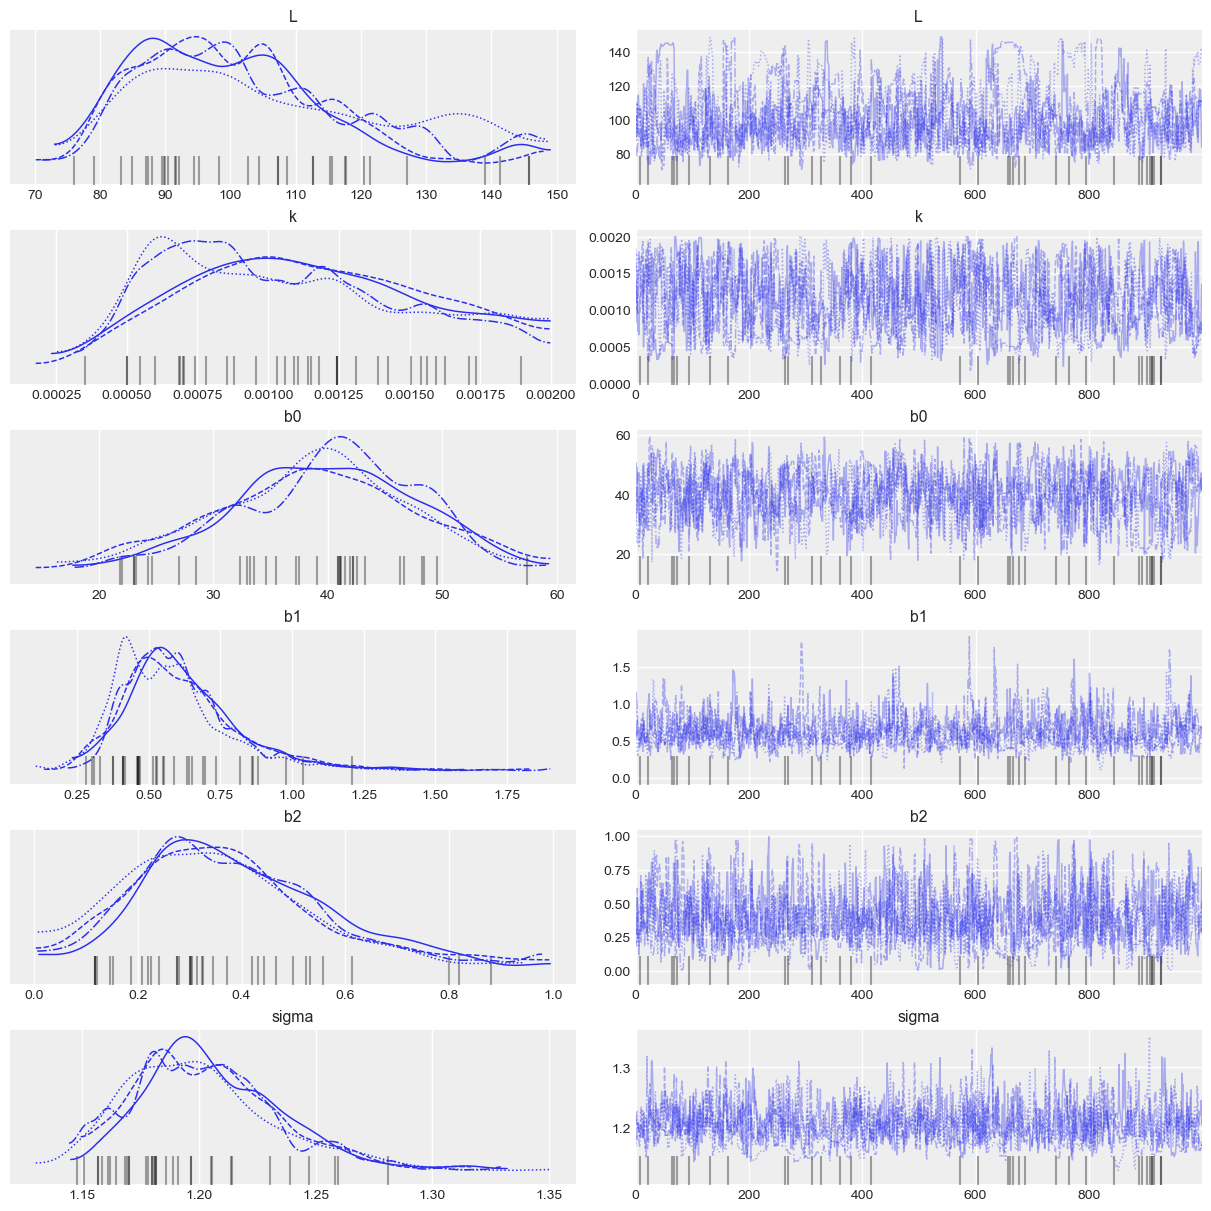

In [14]:
# plot the traces:

az.plot_trace(trace2);

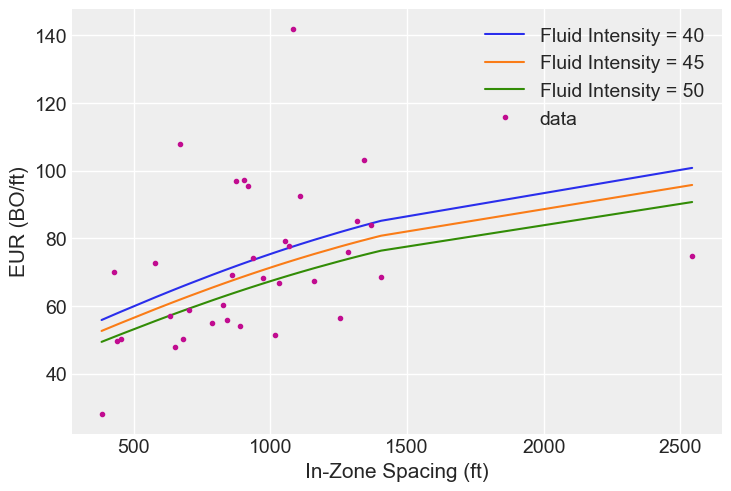

In [15]:
# view the fit lines for a range of completion fluid intensities:

Lb = trace2['L'].mean()
kb = trace2['k'].mean()
b0b = trace2['b0'].mean()
b1b = trace2['b1'].mean()
b2b = trace2['b2'].mean()

for i in [40, 45, 50]:
    fl_mult = ((45 - i) * b2b / 45 + 1)
    sd_mult = 1
    yhat_bayes = fl_mult * sd_mult * (2 * (Lb - b0b)) / (1 + np.exp(-kb * (spcg - 0))) - (2 * (Lb - b0b)) / 2 + b0b
    plt.plot(spcg, yhat_bayes, label='Fluid Intensity = {0:2g}'.format(i))
    
plt.plot(spcg, eurpft, '.', label='data')

plt.ylabel('EUR (BO/ft)')
plt.xlabel('In-Zone Spacing (ft)')
plt.legend()

In [16]:
# simulate data for a more complete view of the mean range and simulated variance:

n_samps = 100000

xsims = []
yhats = []
ysims = []

for i in range(n_samps):
    idx = np.random.choice(range(len(trace2)))
    r = trace2[idx]
    xsim = np.random.uniform(spcg.min(), spcg.max())
    yhat = (2 * (r['L'] - r['b0'])) / (1 + np.exp(-r['k'] * (xsim - 0))) - (2 * (r['L'] - r['b0'])) / 2 + r['b0']
    ysim = np.exp(np.random.normal(np.log(yhat), np.log(r['sigma'])))
    xsims.append(xsim)
    yhats.append(yhat)
    ysims.append(ysim)

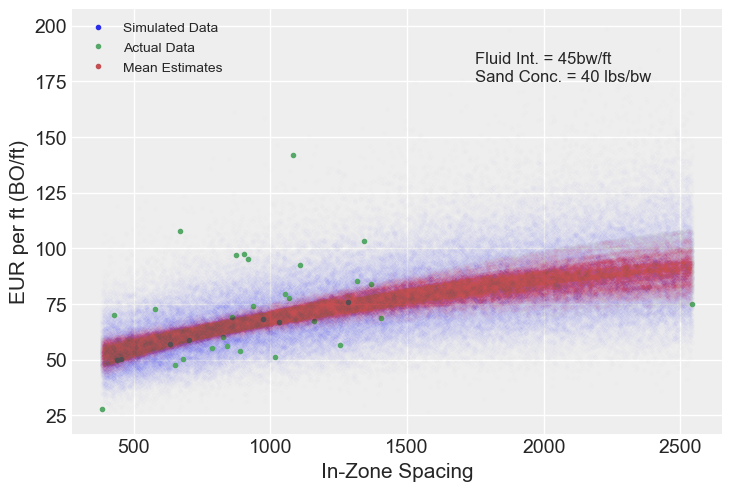

In [17]:
# plot the simulated data:

plt.plot(xsims, ysims, '.', alpha=500/n_samps, label='Simulated Data')
plt.plot(spcg, eurpft, 'g.', label='Actual Data')
plt.plot(xsims, yhats, 'r.', alpha=200/n_samps, label='Mean Estimates')

for i in plt.legend(loc='upper left', fontsize=10).legendHandles:
    i.set_alpha(1)

plt.ylabel('EUR per ft (BO/ft)')
plt.xlabel('In-Zone Spacing')
plt.text(1750, 175, 'Fluid Int. = 45bw/ft \n\
Sand Conc. = 40 lbs/bw');

In [18]:
# define a function that simulates data for a fixed spacing and completion fluid intensity:

def estimate_fixed_spcg(x_val, fi, n_samps=1000):
    yhats = []
    ysims = []

    for i in range(n_samps):
        idx = np.random.choice(range(len(trace2)))
        r = trace2[idx]
        fl_mult = ((fi - 45) * r['b1'] / 45 + 1)
        yhat = fl_mult * (2 * (r['L'] - r['b0'])) / (1 + np.exp(-r['k'] * (x_val - 0))) - (2 * (r['L'] - r['b0'])) / 2 + r['b0']
        ysim = np.exp(np.random.normal(np.log(yhat), np.log(r['sigma'])))
        yhats.append(yhat)
        ysims.append(ysim)
        
    return ysims, yhats

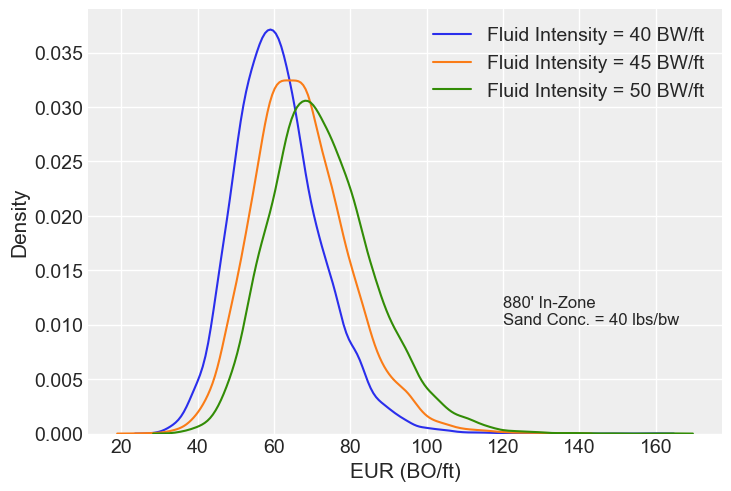

In [19]:
# visualize an example for three fluid intensities at 880' in-zone spacing:

x_val = 880
fi = 45

fi40, _ = estimate_fixed_spcg(880, 40, n_samps=10000)
fi45, _ = estimate_fixed_spcg(880, 45, n_samps=10000)
fi50, _ = estimate_fixed_spcg(880, 50, n_samps=10000)

sns.kdeplot(fi40, label='Fluid Intensity = 40 BW/ft')
sns.kdeplot(fi45, label='Fluid Intensity = 45 BW/ft')
sns.kdeplot(fi50, label='Fluid Intensity = 50 BW/ft')
plt.legend()
plt.xlabel('EUR (BO/ft)')
plt.text(120, .01, "880' In-Zone\n\
Sand Conc. = 40 lbs/bw");